In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

# Data

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


z= 0.06343
gal_name = "spec-was49"

arr = fits.open(gal_name+'.fits')


#flux      float32   coadded calibrated flux [10-17 ergs/s/cm2/Å]
#loglam    float32   log10(wavelength [Å])
#ivar      float32   inverse variance of flux
#and_mask  int32     AND mask
#or_mask   int32     OR mask
#wdisp     float32   wavelength dispersion in pixel=dloglam units
#sky       float32   subtracted sky flux [10-17 ergs/s/cm2/Å]
#model     float32   pipeline best model fit used for classification and redshift

flux, lam, ivar, and_mask, or_mark, wdisp, sky, model = [], [], [], [], [], [], [], []
dnew = []

for i in range(len(arr[1].data)):
    d = arr[1].data[i]
    flux.append(d[0]*1e17) 
    lam.append(10**d[1])
    ivar.append(d[2]) #and_mask.append(d[3]), or_mark.append(d[4]), wdisp.append(d[5]), sky.append(d[6]), model..append(d[7])

    dnew = np.column_stack([lam, flux, ivar])

    with open(gal_name+".txt",'w+') as file:
        np.savetxt(file, dnew, fmt=['%f','%f', '%f'])
                

In [5]:
file_path = './'+gal_name+'.txt'

t = np.loadtxt(file_path, unpack="True", dtype=float)

wl = t[0]/(1+z)
flux = t[1]*10**-17
err = t[2]

flux_lim = np.where(flux>0)[0]
wl=wl[flux_lim]
flux=flux[flux_lim]
err=err[flux_lim]

wl_lim = np.where((wl>5900)&(wl<6950))
#wl_lim = np.where((wl>6400)&(wl<6800))
wl=wl[wl_lim]
flux=flux[wl_lim]
err=err[wl_lim]

mask1 = np.where((wl<6320)|(wl>6370))
wl=wl[mask1]
flux=flux[mask1]
err=err[mask1]

#plt.plot(wl, flux, '.k')
#plt.xlim(5500, 7500)
#plt.ylim(-1, 300)
#plt.show()

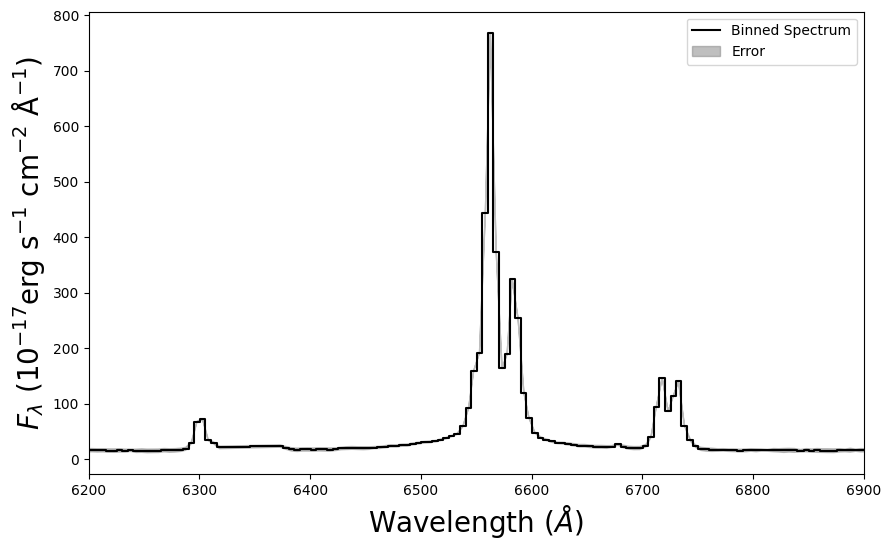

In [6]:
bin_width = 5

bins = np.arange(min(wl), max(wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(wl, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
        binned_flux_err.append(np.mean(err[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
#plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
plt.xlabel("Wavelength ($\AA$)", fontsize=20)
plt.ylabel(r"$F_{\lambda}~(10^{-17} \mathrm{erg~s^{-1}~cm^{-2}~\AA^{-1}})$", fontsize=20)
plt.xlim(6200, 6900)
#plt.ylim(0, 100)
plt.legend()
plt.show()

## Functions

In [7]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [8]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [9]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    width = fwhm/np.sqrt(8*np.log(2))
    #print(cent, fwhm, width)
    
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(width),
                      PyspeckitWarning)


    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [10]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                         sii1_f,sii1_cent,sii1_fwhm,\
                         sii2_f,sii2_cent,sii2_fwhm,\
                         halpha1_f,halpha1_cent,halpha1_fwhm,\
                         halpha2_f,halpha2_cent,halpha2_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)      

    # broad [S II] - 6718.85 & 6733.72
    sii1 = gaussian(x,sii1_f,sii1_cent,sii1_fwhm,normalized=False)
    sii2 = gaussian(x,sii2_f,sii2_cent,sii2_fwhm,normalized=False)
    
    # narrow and broad halpha line
    halpha1 = gaussian(x,halpha1_f,halpha1_cent,halpha1_fwhm,normalized=False)
    halpha2 = gaussian(x,halpha2_f,halpha2_cent,halpha2_fwhm,normalized=False)

    y = pl + sii1 + sii2 + halpha1 + halpha2 
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
            'sii1':sii1,\
            'sii2':sii2,\
            'halpha1':halpha1,\
            'halpha2':halpha2} 
    
    return y

In [11]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [12]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [13]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 14,
            parnames=['pl_s','pl_e',\
                     'sii1_f','sii1_cent','sii1_fwhm',\
                     'sii2_f','sii2_cent','sii2_fwhm',\
                     'halpha1_f','halpha1_cent','halpha1_fwhm',\
                     'haplha2_f','halpha2_cent','halpha2_fwhm'], 
            parlimited=[(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),], 
            parlimits=[(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [14]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    sii= model['sii1'] + model['sii2']
    halpha = model['halpha1'] + model['halpha2']
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,sii,color=pink)
    ax.plot(wave,halpha,color=pink)
    ax.set_xlim(wavemin,wavemax)
    #ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(4700,5100)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(3715,4450)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)

## Setup for plotting

In [15]:
import matplotlib
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [16]:
flux = binned_flux
lam = binned_wl
err = binned_flux_err


In [17]:
sii1 = 6718.85
sii2 = 6585.64
halpha = 6564.93


c = 2.99e5 # km/s

In [18]:
guesses = [5,0,\
          10, sii1, 1000,\
          10, sii2, 1000,\
          5, halpha, 4000,\
          10, halpha, 1000]
           
tied = ['','',\
       '', '', '',\
       '', '', '',\
       '', '', '',\
       '', '', '',]

step = [0.5, 0.05,\
       0.5, 0.1, 5,\
       0.5, 0.1, 5,\
       0.5, 0.1, 5,\
       0.5, 0.1, 5]

fixed = [0,0,\
        0,0,0,\
        0,0,0,\
        0,0,0,\
        0,0,0]

In [19]:
print(len(guesses))

14


In [21]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),11)
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)



INFO: Left region selection unchanged.  xminpix, xmaxpix: 19,200 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  4.041842866e+11  DOF =  167
   PL_S0 = 5  
   PL_E0 = 0  
   SII1_F0 = 10  
   SII1_CENT0 = 6718.85  
   SII1_FWHM0 = 1000  
   SII2_F0 = 10  
   SII2_CENT0 = 6585.64  
   SII2_FWHM0 = 1000  
   HALPHA1_F0 = 5  
   HALPHA1_CENT0 = 6564.93  
   HALPHA1_FWHM0 = 4000  
   HAPLHA2_F0 = 10  
   HALPHA2_CENT0 = 6564.93  
   HALPHA2_FWHM0 = 1000  
Iter       2    CHI-SQUARE =  4626956038  DOF =  167
   PL_S0 = 21.54799463  
   PL_E0 = -1.84303236  
   SII1_F0 = 12.99566135  
   SII1_CENT0 = 6722.02331  
   SII1_FWHM0 = 1337.680826  
   SII2_F0 = 58.78881003  
   SII2_CENT0 = 6473.771297  
   SII2_FWHM0 = 6499.541029  
   HALPHA1_F0 = 21.64081741  
   HALPHA1_CENT0 = 5588.502169  
   HALPHA1_FWHM0 = 71765.17887  
   HAPLHA2_F0 = 27.29079447  
   HALPHA2_CENT0 = 6502.551775  
   HALPHA2_FWHM0 = 9215.288914  
Iter       3    CHI-SQUARE =  4552365376  DOF =  167
   PL_S0

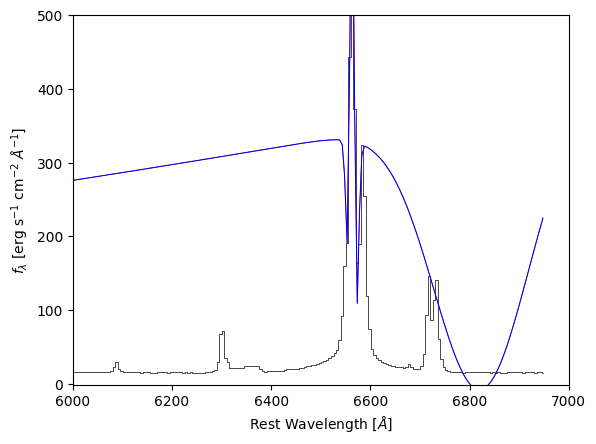

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6000,xmax=7000,ymin=-1,ymax=500,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

In [23]:
import scipy
c = 3e5 #km/s
H0 = 71.0 #km Mpc^-1 s^-1
d_H = c/H0

def CMD(z):
    function = lambda z: (0.3*(1.0+z)**3.0 + 0.7)**-0.5
    integral = scipy.integrate.quad(function,0,z)
    return (1+z)*d_H*integral[0]*3.086e24


def SMBH(lum, fwhm):
    #M = 2.0e6*(lum/1e42)**(0.55) * (np.abs(fwhm)/1e3)**(2.06)
    M = 10**(6.71 + 0.48*np.log10(lum/1e42) + 2.12*np.log10(np.abs(fwhm)/1000))
    return(M)

PL_S0, PL_E0, SII1_F0, SII1_CENT0, SII1_FWHM0, SII2_F0, SII2_CENT0, SII2_FWHM0, HALPHA1_F0, HALPHA1_CENT0, HALPHA1_FWHM0, HALPHA2_F0, HALPHA2_CENT0, HALPHA2_FWHM0 = spec.specfit.parinfo.values

index = np.argmax((np.abs(HALPHA1_FWHM0), np.abs(HALPHA2_FWHM0)))
if index == 0:
    fwhm_use = HALPHA1_FWHM0
    flux_use = HALPHA1_F0
elif index == 1:
    fwhm_use = HALPHA2_FWHM0
    flux_use = HALPHA2_F0


HALPHA_LUM = flux_use*10**-17*(4*np.pi*CMD(z)**2.0)
Mass = SMBH(HALPHA_LUM, fwhm_use)
print(HALPHA_LUM, Mass/1e8, (1.25e38*Mass)/1e40)


2.1542176087630283e+39 0.2997652776688403 374706.5970860503


200


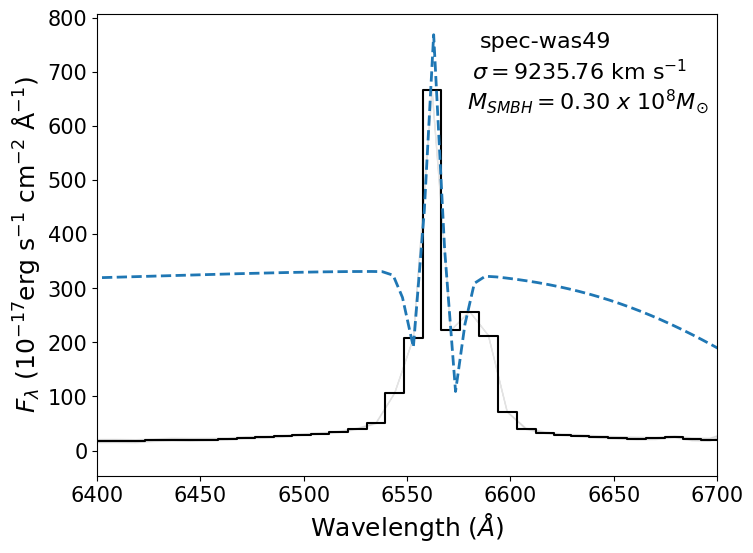

In [24]:
file_path = './'+gal_name+'.txt'

t = np.loadtxt(file_path, unpack="True", dtype=float)

wl = t[0]/(1+z)
flux = t[1]*10**-17
err = t[2]

flux_lim = np.where(flux>0)[0]
wl=wl[flux_lim]
flux=flux[flux_lim]
err=err[flux_lim]

wl_lim = np.where((wl>5900)&(wl<6950))
#wl_lim = np.where((wl>6400)&(wl<6800))
wl=wl[wl_lim]
flux=flux[wl_lim]
err=err[wl_lim]

PL_S0, PL_E0, SII1_F0, SII1_CENT0, SII1_FWHM0, SII2_F0, SII2_CENT0, SII2_FWHM0, HALPHA1_F0, HALPHA1_CENT0, HALPHA1_FWHM0, HALPHA2_F0, HALPHA2_CENT0, HALPHA2_FWHM0 = spec.specfit.parinfo.values

print(len(lam))
lamm = lam #np.linspace(min(lam), max(lam), 100)
# powerlaw
pl = powerlaw(lamm,PL_S0,PL_E0)      

# broad [S II] - 6718.85 & 6733.72
sii1 = gaussian(lamm,SII1_F0, SII1_CENT0, SII1_FWHM0, normalized=False)
sii2 = gaussian(lamm, SII2_F0, SII2_CENT0, SII2_FWHM0, normalized=False)

# narrow and broad halpha line
halpha1 = gaussian(lamm,HALPHA1_F0, HALPHA1_CENT0, HALPHA1_FWHM0,normalized=False)
halpha2 = gaussian(lamm,HALPHA2_F0, HALPHA2_CENT0, HALPHA2_FWHM0,normalized=False)

y = pl + sii1 + sii2 + halpha1 + halpha2 

bin_width = 9

bins = np.arange(min(wl), max(wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(wl, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
        binned_flux_err.append(np.mean(err[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(8, 6))
plt.plot(binned_wl, binned_flux, color="black", drawstyle='steps-mid')
plt.plot(lamm, y, ls="--", lw="2")
plt.annotate(r"$\sigma = $"+str("{:.2f}".format(np.abs(fwhm_use))+" km s$^{-1}$"), xy=(425, 300), xycoords='axes points',
            size=16, ha='right', va='top')
plt.annotate(r"$M_{SMBH} = $"+str("{:.2f}".format(Mass/1e8))+" $x ~10^{8} M_{\odot}$", xy=(440, 280), xycoords='axes points',
            size=16, ha='right', va='top')
plt.annotate(gal_name[-10:], xy=(370, 320), xycoords='axes points',
            size=16, ha='right', va='top')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.2)
#plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
plt.xlabel("Wavelength ($\AA$)", fontsize=18)
plt.ylabel(r"$F_{\lambda}~(10^{-17} \mathrm{erg~s^{-1}~cm^{-2}~\AA^{-1}})$", fontsize=18)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(6400, 6700)
#plt.ylim(0, 100)
plt.savefig(gal_name+"_spectralfit.pdf")
plt.show()

In [ ]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
#ymin = -100.
#ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-10,150,'Wavelength $[\AA]$',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)